In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from analysis_dependencies import get_uvmet
from analysis_dependencies import get_wrf_slp
from analysis_dependencies import get_wrf_rh
from analysis_dependencies import get_wrf_tk
from analysis_dependencies import get_wrf_th
from analysis_dependencies import get_wrf_ss
from analysis_dependencies import gen_wrf_proj
from analysis_dependencies import gen_cartopy_proj
from analysis_dependencies import get_wrf_kinematic
from analysis_dependencies import plan_section_plot
from analysis_dependencies import cross_section_plot
import datetime
import wrf
import cartopy
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr

In [2]:
unpDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/march2020/R_mu/unperturbed/'
ptdDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/march2020/R_mu/negative/uvTq/ptdi14/'
arcDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/case_archives/march2020/R_mu/negative/uvTq/'
arcPtd = '14'
dtInit = datetime.datetime(2020, 3, 6, 12)

In [3]:
fcstHr = 24
dtFcst = dtInit + datetime.timedelta(hours=fcstHr)
dtInitStr = datetime.datetime.strftime(dtInit,'%Y-%m-%d_%H:00:00')
dtFcstStr = datetime.datetime.strftime(dtFcst,'%Y-%m-%d_%H:00:00')
unpWRFInputFile = arcDir + 'wrfinput_d01_unpi00'
ptdWRFInputFile = arcDir + 'wrfinput_d01_ptdi' + arcPtd
unpFileInit = unpDir + 'wrfout_d01_' + dtInitStr
ptdFileInit = ptdDir + 'wrfout_d01_' + dtInitStr
unpFileFcst = unpDir + 'wrfout_d01_' + dtFcstStr
ptdFileFcst = ptdDir + 'wrfout_d01_' + dtFcstStr
unpHdlInit = Dataset(unpFileInit)
ptdHdlInit = Dataset(ptdFileInit)
unpHdlFcst = Dataset(unpFileFcst)
ptdHdlFcst = Dataset(ptdFileFcst)

In [4]:
lat = np.asarray(unpHdlInit.variables['XLAT']).squeeze()
lon = np.asarray(unpHdlInit.variables['XLONG']).squeeze()
fix = np.where(lon < 0.)
lon[fix] = lon[fix] + 360.

datProj = gen_cartopy_proj(unpHdlInit)
plotProj = ccrs.PlateCarree()

unpSLPInit = np.asarray(get_wrf_slp(unpHdlInit)).squeeze()
ptdSLPInit = np.asarray(get_wrf_slp(ptdHdlInit)).squeeze()
unpSLPFcst = np.asarray(get_wrf_slp(unpHdlFcst)).squeeze()
ptdSLPFcst = np.asarray(get_wrf_slp(ptdHdlFcst)).squeeze()

unpRHInit = np.asarray(get_wrf_rh(unpHdlInit)).squeeze()
ptdRHInit = np.asarray(get_wrf_rh(ptdHdlInit)).squeeze()

unpHGTInit = np.asarray(wrf.getvar(unpHdlInit,'z')).squeeze()
ptdHGTInit = np.asarray(wrf.getvar(ptdHdlInit,'z')).squeeze()
unpHGTFcst = np.asarray(wrf.getvar(unpHdlFcst,'z')).squeeze()
ptdHGTFcst = np.asarray(wrf.getvar(ptdHdlFcst,'z')).squeeze()

unpTHTAInit = np.asarray(wrf.getvar(unpHdlInit,'theta')).squeeze()
ptdTHTAInit = np.asarray(wrf.getvar(ptdHdlInit,'theta')).squeeze()
unpTHTAFcst = np.asarray(wrf.getvar(unpHdlFcst,'theta')).squeeze()
ptdTHTAFcst = np.asarray(wrf.getvar(ptdHdlFcst,'theta')).squeeze()

unpPInit = np.asarray(wrf.getvar(unpHdlInit,'p')).squeeze()
ptdPInit = np.asarray(wrf.getvar(ptdHdlInit,'p')).squeeze()
unpPFcst = np.asarray(wrf.getvar(unpHdlFcst,'p')).squeeze()
ptdPFcst = np.asarray(wrf.getvar(ptdHdlFcst,'p')).squeeze()

unpUWDInit, unpVWDInit = np.asarray(get_uvmet(unpHdlInit))
unpUWDFcst, unpVWDFcst = np.asarray(get_uvmet(unpHdlFcst))
ptdUWDInit, ptdVWDInit = np.asarray(get_uvmet(ptdHdlInit))
ptdUWDFcst, ptdVWDFcst = np.asarray(get_uvmet(ptdHdlFcst))

plevs=np.arange(1000.,102000.,50.)

In [5]:
unpVORInit = get_wrf_kinematic(unpHdlInit,'vor')
unpDIVInit = get_wrf_kinematic(unpHdlInit,'div')
unpSTRInit = get_wrf_kinematic(unpHdlInit,'str')
unpSHRInit = get_wrf_kinematic(unpHdlInit,'shr')
unpDEFInit = (unpSTRInit**2. + unpSHRInit**2.)**0.5

ptdVORInit = get_wrf_kinematic(ptdHdlInit,'vor')
ptdDIVInit = get_wrf_kinematic(ptdHdlInit,'div')
ptdSTRInit = get_wrf_kinematic(ptdHdlInit,'str')
ptdSHRInit = get_wrf_kinematic(ptdHdlInit,'shr')
ptdDEFInit = (ptdSTRInit**2. + ptdSHRInit**2.)**0.5

In [6]:
# compute 850 and 500 potential temperature and winds
pk = 85000.  # Pa
unpVar1 = wrf.interplevel(field3d=unpHGTInit,
                          vert=unpPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
ptdVar1 = wrf.interplevel(field3d=ptdHGTInit,
                          vert=ptdPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
unpUWD850Init = wrf.interplevel(field3d=unpUWDInit,
                                vert=unpPInit,
                                desiredlev=pk,
                                missing=np.nan,
                                squeeze=True,
                                meta=False)
unpUWD850Fcst = wrf.interplevel(field3d=unpUWDFcst,
                                vert=unpPFcst,
                                desiredlev=pk,
                                missing=np.nan,
                                squeeze=True,
                                meta=False)
ptdUWD850Init = wrf.interplevel(field3d=ptdUWDInit,
                                vert=ptdPInit,
                                desiredlev=pk,
                                missing=np.nan,
                                squeeze=True,
                                meta=False)
ptdUWD850Fcst = wrf.interplevel(field3d=ptdUWDFcst,
                                vert=ptdPFcst,
                                desiredlev=pk,
                                missing=np.nan,
                                squeeze=True,
                                meta=False)
pk = 50000.  # Pa
unpVar2 = wrf.interplevel(field3d=unpHGTInit,
                          vert=unpPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
ptdVar2 = wrf.interplevel(field3d=ptdHGTInit,
                          vert=ptdPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
unpUWD500Init = wrf.interplevel(field3d=unpUWDInit,
                                vert=unpPInit,
                                desiredlev=pk,
                                missing=np.nan,
                                squeeze=True,
                                meta=False)
unpUWD500Fcst = wrf.interplevel(field3d=unpUWDFcst,
                                vert=unpPFcst,
                                desiredlev=pk,
                                missing=np.nan,
                                squeeze=True,
                                meta=False)
ptdUWD500Init = wrf.interplevel(field3d=ptdUWDInit,
                                vert=ptdPInit,
                                desiredlev=pk,
                                missing=np.nan,
                                squeeze=True,
                                meta=False)
ptdUWD500Fcst = wrf.interplevel(field3d=ptdUWDFcst,
                                vert=ptdPFcst,
                                desiredlev=pk,
                                missing=np.nan,
                                squeeze=True,
                                meta=False)
unpHGT850Init = unpVar1
unpHGT500Init = unpVar2
unpThk850_500Init = unpVar2 - unpVar1
ptdHGT850Init = ptdVar1
ptdHGT500Init = ptdVar2
ptdThk850_500Init = ptdVar2 - ptdVar1
pk = 85000.  # Pa
unpVar1 = wrf.interplevel(field3d=unpHGTInit,
                          vert=unpPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
ptdVar1 = wrf.interplevel(field3d=ptdHGTInit,
                          vert=ptdPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
pk = 50000.  # Pa
unpVar2 = wrf.interplevel(field3d=unpHGTFcst,
                          vert=unpPFcst,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
ptdVar2 = wrf.interplevel(field3d=ptdHGTFcst,
                          vert=ptdPFcst,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
unpHGT850Fcst = unpVar1
unpHGT500Fcst = unpVar2
unpThk850_500Fcst = unpVar2 - unpVar1
ptdHGT850Fcst = ptdVar1
ptdHGT500Fcst = ptdVar2
ptdThk850_500Fcst = ptdVar2 - ptdVar1

In [7]:
# compute 850 and 500 geopotential heights, 850-500 thicknesses
pk = 85000.  # Pa
unpVar1 = wrf.interplevel(field3d=unpHGTInit,
                          vert=unpPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
ptdVar1 = wrf.interplevel(field3d=ptdHGTInit,
                          vert=ptdPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
pk = 50000.  # Pa
unpVar2 = wrf.interplevel(field3d=unpHGTInit,
                          vert=unpPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
ptdVar2 = wrf.interplevel(field3d=ptdHGTInit,
                          vert=ptdPInit,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
unpHGT850Init = unpVar1
unpHGT500Init = unpVar2
unpThk850_500Init = unpVar2 - unpVar1
ptdHGT850Init = ptdVar1
ptdHGT500Init = ptdVar2
ptdThk850_500Init = ptdVar2 - ptdVar1
pk = 85000.  # Pa
unpVar1 = wrf.interplevel(field3d=unpHGTFcst,
                          vert=unpPFcst,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
ptdVar1 = wrf.interplevel(field3d=ptdHGTFcst,
                          vert=ptdPFcst,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
pk = 50000.  # Pa
unpVar2 = wrf.interplevel(field3d=unpHGTFcst,
                          vert=unpPFcst,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
ptdVar2 = wrf.interplevel(field3d=ptdHGTFcst,
                          vert=ptdPFcst,
                          desiredlev=pk,
                          missing=np.nan,
                          squeeze=True,
                          meta=False)
unpHGT850Fcst = unpVar1
unpHGT500Fcst = unpVar2
unpThk850_500Fcst = unpVar2 - unpVar1
ptdHGT850Fcst = ptdVar1
ptdHGT500Fcst = ptdVar2
ptdThk850_500Fcst = ptdVar2 - ptdVar1

generating 2 contours


<a list of 16 text.Text objects>

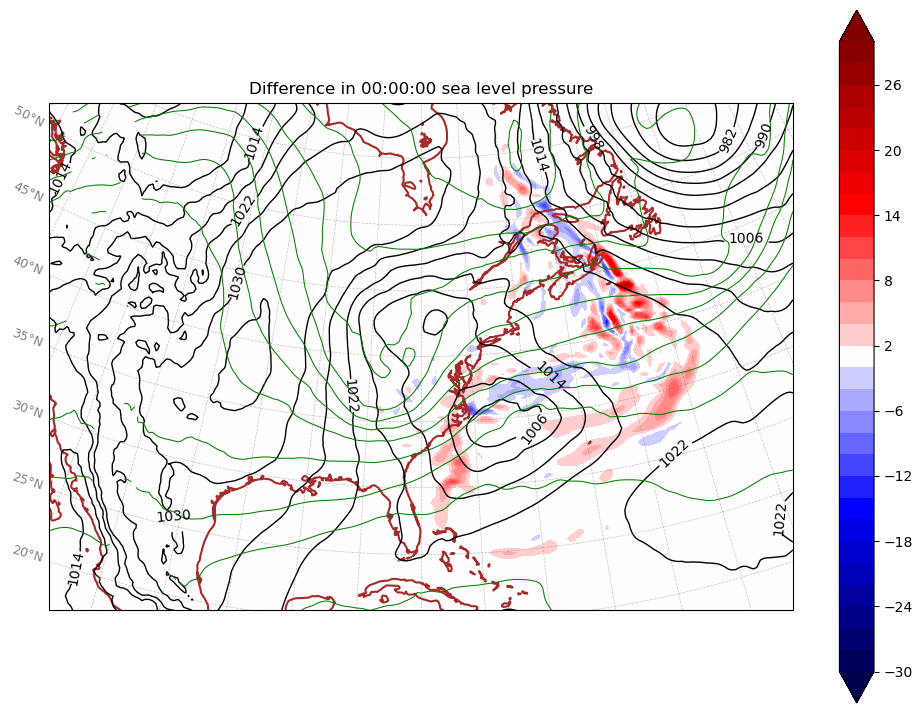

In [8]:
shdrng = np.arange(-30.,30.1,2.)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False
slprng = np.arange(950.,1050.1,4.)
thkrng = np.arange(3700.,4500.1,50.)

fig, (shd, cons, vec) = plan_section_plot(wrfHDL=unpHdlInit,
                                        lat=lat,
                                        lon=lon,
                                        contVariableList=[unpSLPInit,unpThk850_500Init],
                                        contIntervalList=[slprng,thkrng], 
                                        contColorList=['black','green'],
                                        contLineThicknessList=[1.0,0.75],
                                        shadVariable=ptdSLPInit-unpSLPInit,
                                        shadInterval=shdrng[mask],
                                        shadAlpha=1.0,
                                        datProj=datProj,
                                        plotProj=plotProj,
                                        shadCmap='seismic',
                                        uVecVariable=None,
                                        vVecVariable=None,
                                        vectorThinning=None,
                                        vecColor=None)
# add a title
fig.gca().set_title('Difference in 00:00:00 sea level pressure')
# add contour labels to slp
fig.gca().clabel(cons[0],levels=slprng[::2])

generating 2 contours


<a list of 19 text.Text objects>

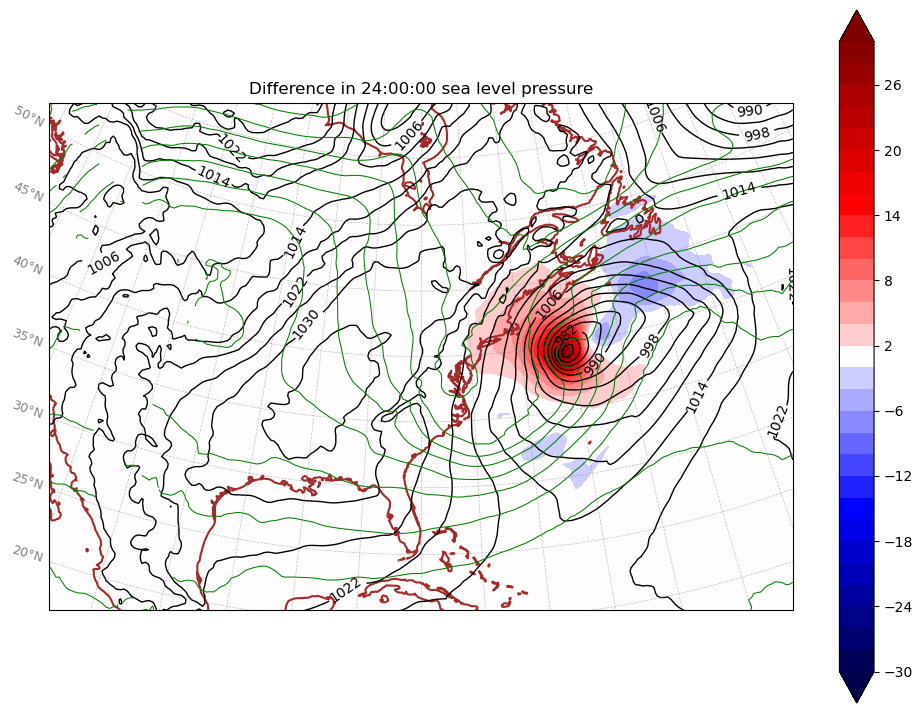

In [9]:
shdrng = np.arange(-30.,30.1,2.)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False
slprng = np.arange(950.,1050.1,4.)
thkrng = np.arange(3700.,4500.1,50.)

fig, (shd, cons, vec) = plan_section_plot(wrfHDL=unpHdlFcst,
                                        lat=lat,
                                        lon=lon,
                                        contVariableList=[unpSLPFcst,unpThk850_500Fcst],
                                        contIntervalList=[slprng,thkrng], 
                                        contColorList=['black','green'],
                                        contLineThicknessList=[1.0,0.75],
                                        shadVariable=ptdSLPFcst-unpSLPFcst,
                                        shadInterval=shdrng[mask],
                                        shadAlpha=1.0,
                                        datProj=datProj,
                                        plotProj=plotProj,
                                        shadCmap='seismic',
                                        uVecVariable=None,
                                        vVecVariable=None,
                                        vectorThinning=None,
                                        vecColor=None)
# add a title
fig.gca().set_title('Difference in ' + str(fcstHr) + ':00:00 sea level pressure')
# add contour labels to slp
fig.gca().clabel(cons[0],levels=slprng[::2])

generating 1 contours


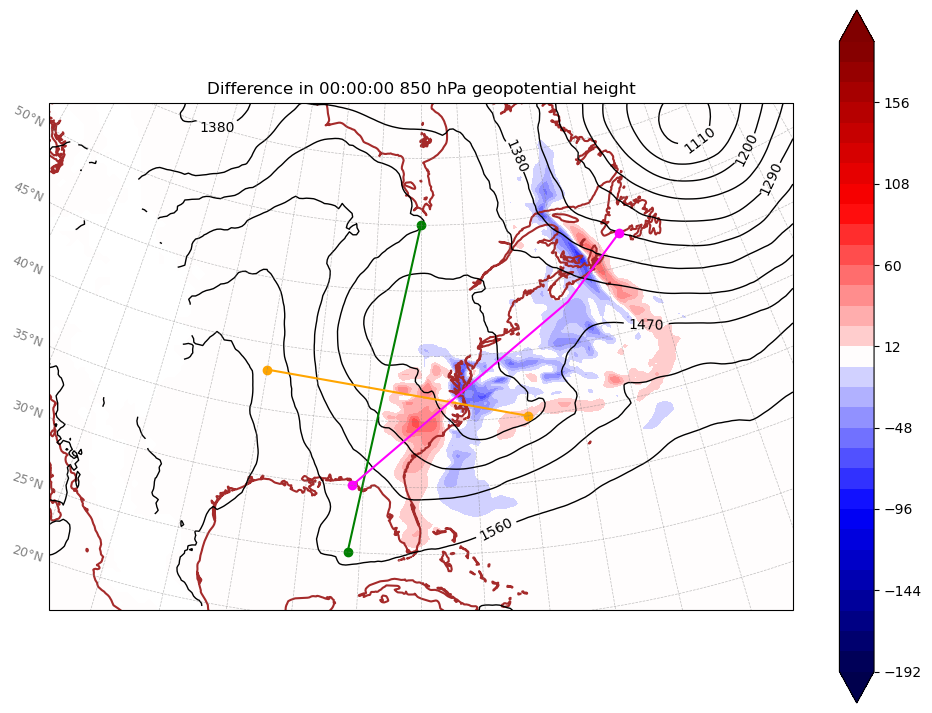

In [11]:
shdrng = np.arange(-192.,192.1,12.)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False
hgtrng = np.arange(1020.,1700.1,45.)

fig, (shd, cons, vec) = plan_section_plot(wrfHDL=unpHdlInit,
                                        lat=lat,
                                        lon=lon,
                                        contVariableList=[unpHGT850Init],
                                        contIntervalList=[hgtrng], 
                                        contColorList=['black'],
                                        contLineThicknessList=[1.0],
                                        shadVariable=ptdHGT850Init-unpHGT850Init,
                                        shadInterval=shdrng[mask],
                                        shadAlpha=1.0,
                                        datProj=datProj,
                                        plotProj=plotProj,
                                        shadCmap='seismic',
                                        uVecVariable=None,
                                        vVecVariable=None,
                                        vectorThinning=None,
                                        vecColor=None)
# add a title
fig.gca().set_title('Difference in 00:00:00 850 hPa geopotential height')
# add contour labels to heights
fig.gca().clabel(cons[0],levels=hgtrng[::2])
# define and plot cross-section
latBeg = 25.
lonBeg = -86.
latEnd = 50.
lonEnd = -80.
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='green')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='green')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='green')
latBeg = 38.
lonBeg = -95.
latEnd = 35.
lonEnd = -70.
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='orange')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='orange')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='orange')
latBeg = 30.
lonBeg = -86.
latEnd = 47.5
lonEnd = -57.5
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='magenta')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='magenta')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='magenta')

generating 1 contours


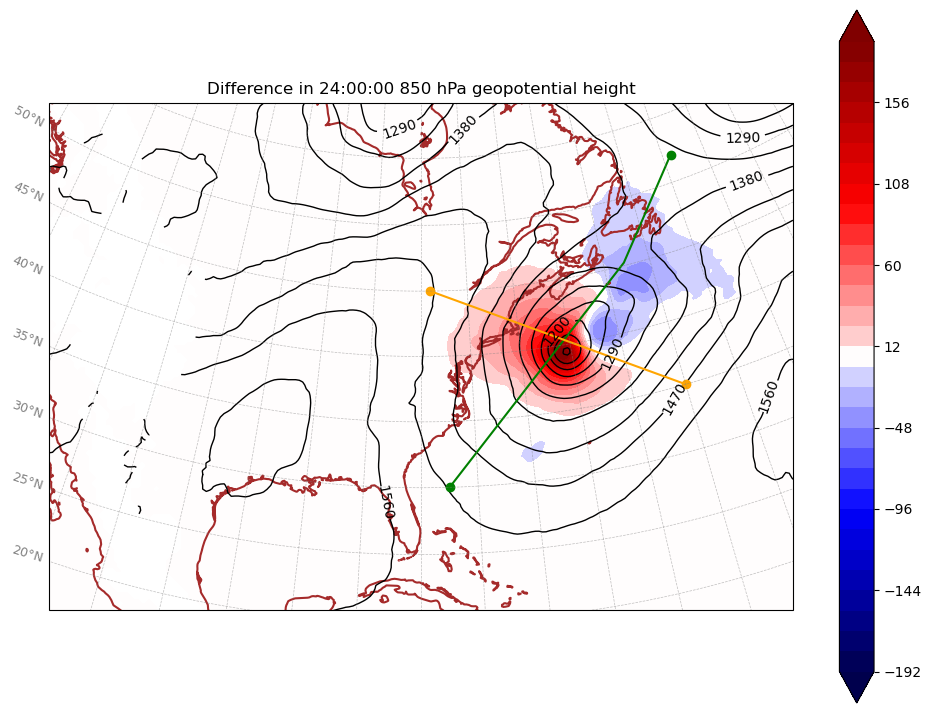

In [12]:
shdrng = np.arange(-192.,192.1,12.)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False
hgtrng = np.arange(1020.,1700.1,45.)

fig, (shd, cons, vec) = plan_section_plot(wrfHDL=unpHdlFcst,
                                        lat=lat,
                                        lon=lon,
                                        contVariableList=[unpHGT850Fcst],
                                        contIntervalList=[hgtrng], 
                                        contColorList=['black'],
                                        contLineThicknessList=[1.0],
                                        shadVariable=ptdHGT850Fcst-unpHGT850Fcst,
                                        shadInterval=shdrng[mask],
                                        shadAlpha=1.0,
                                        datProj=datProj,
                                        plotProj=plotProj,
                                        shadCmap='seismic',
                                        uVecVariable=None,
                                        vVecVariable=None,
                                        vectorThinning=None,
                                        vecColor=None)
# add a title
fig.gca().set_title('Difference in ' + str(fcstHr) + ':00:00 850 hPa geopotential height')
# add contour labels to heights
fig.gca().clabel(cons[0],levels=hgtrng[::2])
# define and plot cross-section
latBeg = 30.
lonBeg = -77.5
latEnd = 52.
lonEnd = -49.
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='green')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='green')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='green')
latBeg = 45.
lonBeg = -79.
latEnd = 35.
lonEnd = -55.
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='orange')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='orange')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='orange')

generating 1 contours


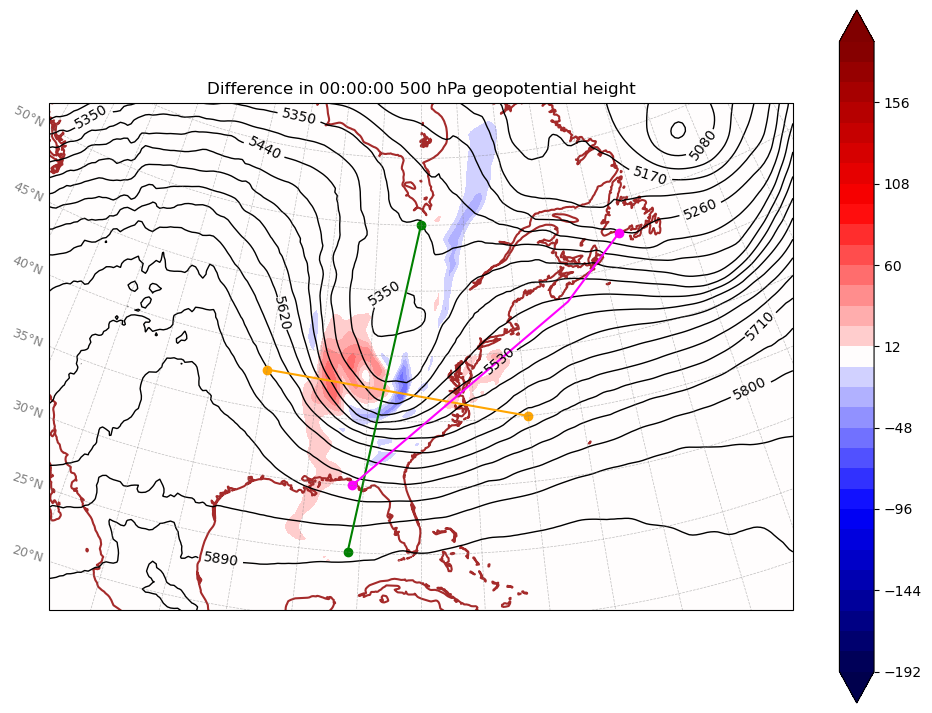

In [13]:
shdrng = np.arange(-192.,192.1,12.)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False
hgtrng = np.arange(4900.,6100.1,45.)

fig, (shd, cons, vec) = plan_section_plot(wrfHDL=unpHdlInit,
                                        lat=lat,
                                        lon=lon,
                                        contVariableList=[unpHGT500Init],
                                        contIntervalList=[hgtrng], 
                                        contColorList=['black'],
                                        contLineThicknessList=[1.0],
                                        shadVariable=ptdHGT500Init-unpHGT500Init,
                                        shadInterval=shdrng[mask],
                                        shadAlpha=1.0,
                                        datProj=datProj,
                                        plotProj=plotProj,
                                        shadCmap='seismic',
                                        uVecVariable=None,
                                        vVecVariable=None,
                                        vectorThinning=None,
                                        vecColor=None)
# add a title
fig.gca().set_title('Difference in 00:00:00 500 hPa geopotential height')
# add contour labels to heights
fig.gca().clabel(cons[0],levels=hgtrng[::2])
# define and plot cross-section
latBeg = 25.
lonBeg = -86.
latEnd = 50.
lonEnd = -80.
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='green')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='green')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='green')
latBeg = 38.
lonBeg = -95.
latEnd = 35.
lonEnd = -70.
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='orange')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='orange')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='orange')
latBeg = 30.
lonBeg = -86.
latEnd = 47.5
lonEnd = -57.5
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='magenta')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='magenta')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='magenta')

generating 1 contours


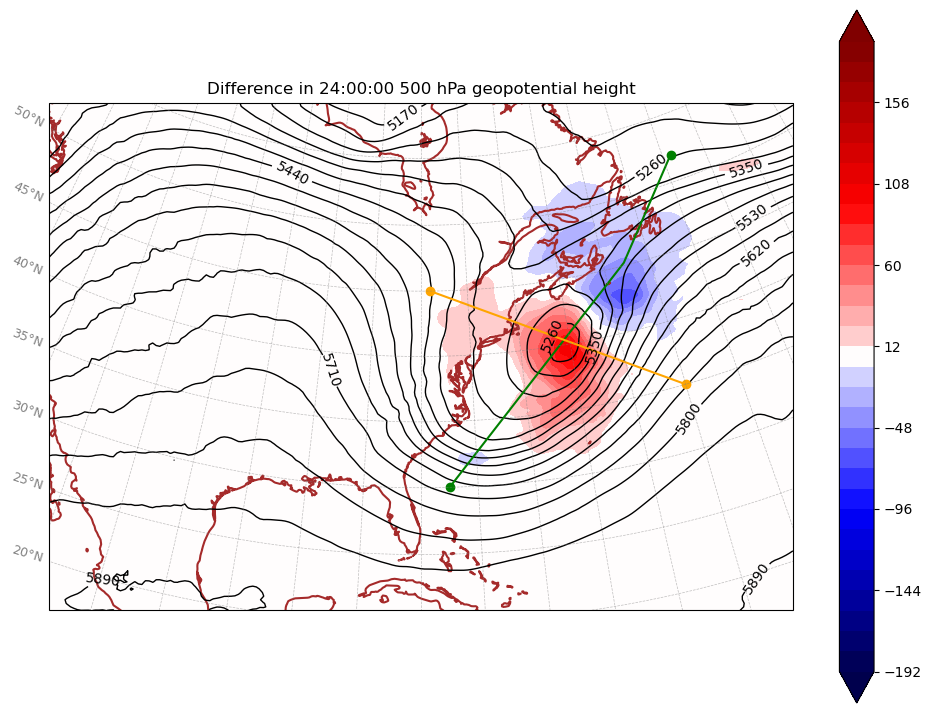

In [14]:
shdrng = np.arange(-192.,192.1,12.)
mask = np.ones((np.shape(shdrng)),dtype='bool')
mask[np.where(shdrng==0.)] = False
hgtrng = np.arange(4900.,6100.1,45.)

fig, (shd, cons, vec) = plan_section_plot(wrfHDL=unpHdlFcst,
                                        lat=lat,
                                        lon=lon,
                                        contVariableList=[unpHGT500Fcst],
                                        contIntervalList=[hgtrng], 
                                        contColorList=['black'],
                                        contLineThicknessList=[1.0],
                                        shadVariable=ptdHGT500Fcst-unpHGT500Fcst,
                                        shadInterval=shdrng[mask],
                                        shadAlpha=1.0,
                                        datProj=datProj,
                                        plotProj=plotProj,
                                        shadCmap='seismic',
                                        uVecVariable=None,
                                        vVecVariable=None,
                                        vectorThinning=None,
                                        vecColor=None)
# add a title
fig.gca().set_title('Difference in ' + str(fcstHr) + ':00:00 500 hPa geopotential height')
# add contour labels to heights
fig.gca().clabel(cons[0],levels=hgtrng[::2])
# define and plot cross-section
latBeg = 30.
lonBeg = -77.5
latEnd = 52.
lonEnd = -49.
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='green')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='green')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='green')
latBeg = 45.
lonBeg = -79.
latEnd = 35.
lonEnd = -55.
fig.gca().plot(lonBeg,latBeg,'o',transform=plotProj,color='orange')
fig.gca().plot(lonEnd,latEnd,'o',transform=plotProj,color='orange')
fig.gca().plot((lonBeg,lonEnd),(latBeg,latEnd),transform=plotProj,color='orange')

In [15]:
unpS = get_wrf_ss(unpHdlInit)
ptdS = get_wrf_ss(ptdHdlInit)

/home/bhoover/miniconda3/envs/UWAOS_WRF_QOIP/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


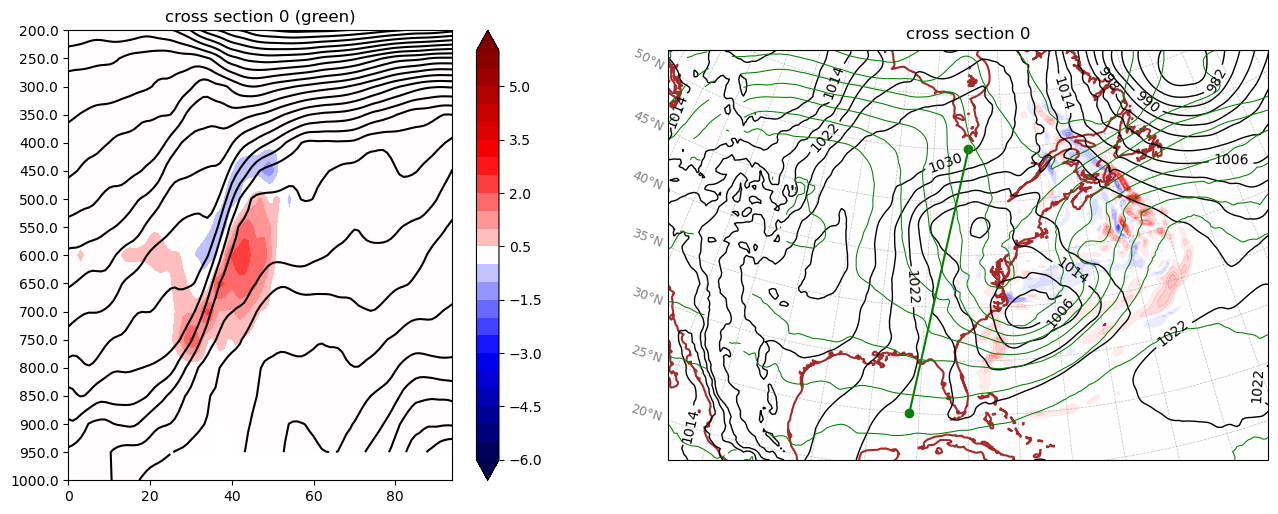

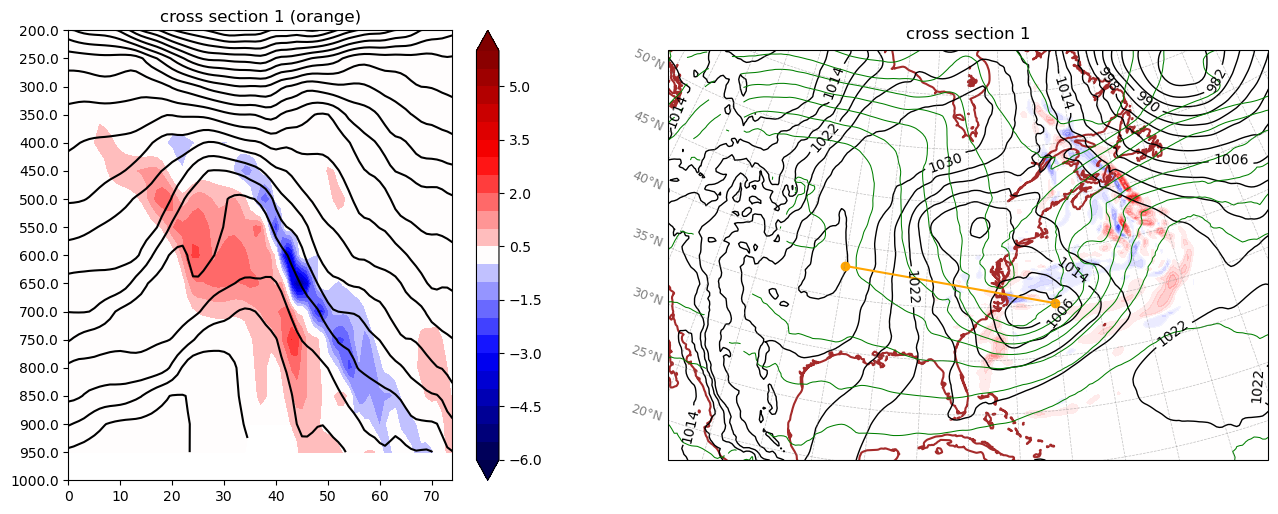

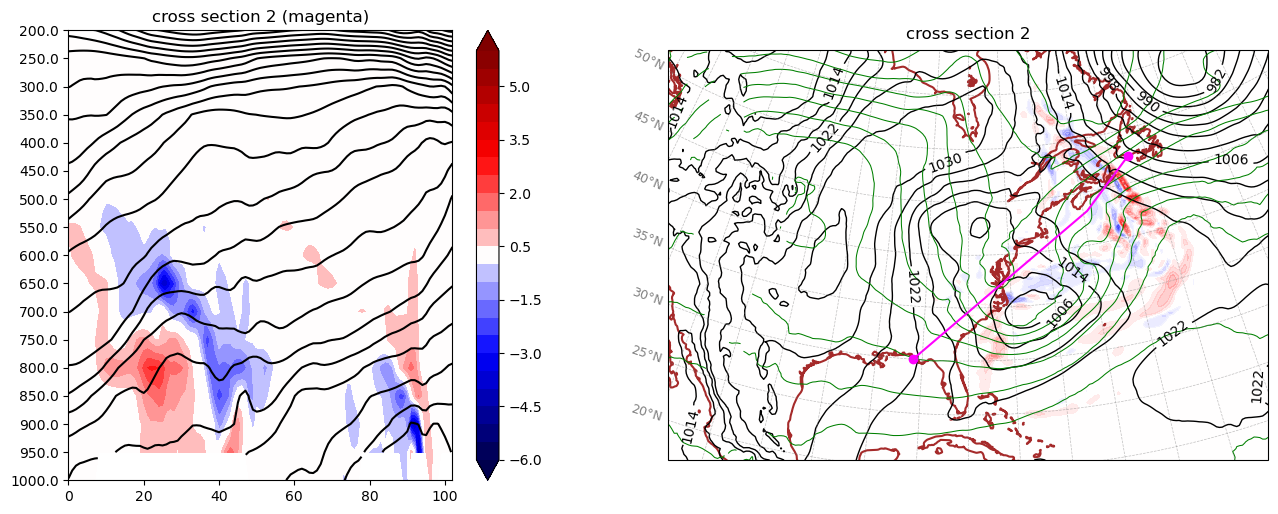

In [16]:
# cross-sections: perturbation potential temperature
wrfHDL = unpHdlInit
latBegList = [ 25.0,  38.0,  30.0]
lonBegList = [-86.0, -95.0, -86.0]
latEndList = [ 50.0,  35.0,  47.5]
lonEndList = [-80.0, -70.0, -57.5]
xSectShadInterval = np.arange(-6., 6.1, 0.5)
xSectShadInterval = xSectShadInterval[np.where(xSectShadInterval != 0.)]
slpPertInterval = np.arange(-30., 30.1, 2.)
slpPertInterval = slpPertInterval[np.where(slpPertInterval != 0.)]
fig = cross_section_plot(wrfHDL=unpHdlInit,
                         latBegList=latBegList,
                         lonBegList=lonBegList,
                         latEndList=latEndList,
                         lonEndList=lonEndList,
                         xSectContVariable=get_wrf_th(unpHdlInit),
                         xSectContInterval=np.arange(250., 450.1, 4.),
                         xSectShadVariable=get_wrf_tk(ptdHdlInit)-get_wrf_tk(unpHdlInit),
                         xSectShadInterval=xSectShadInterval,
                         slp=get_wrf_slp(unpHdlInit),
                         slpInterval=np.arange(950., 1050.1, 4.),
                         thk=unpThk850_500Fcst,
                         thkInterval=np.arange(3700., 4500.1, 50.),
                         slpPert=get_wrf_slp(ptdHdlInit)-get_wrf_slp(unpHdlInit),
                         slpPertInterval=slpPertInterval,
                         datProj=datProj,
                         plotProj=plotProj,
                         presLevMin=20000.
                        )
plt.show(fig)

/home/bhoover/miniconda3/envs/UWAOS_WRF_QOIP/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


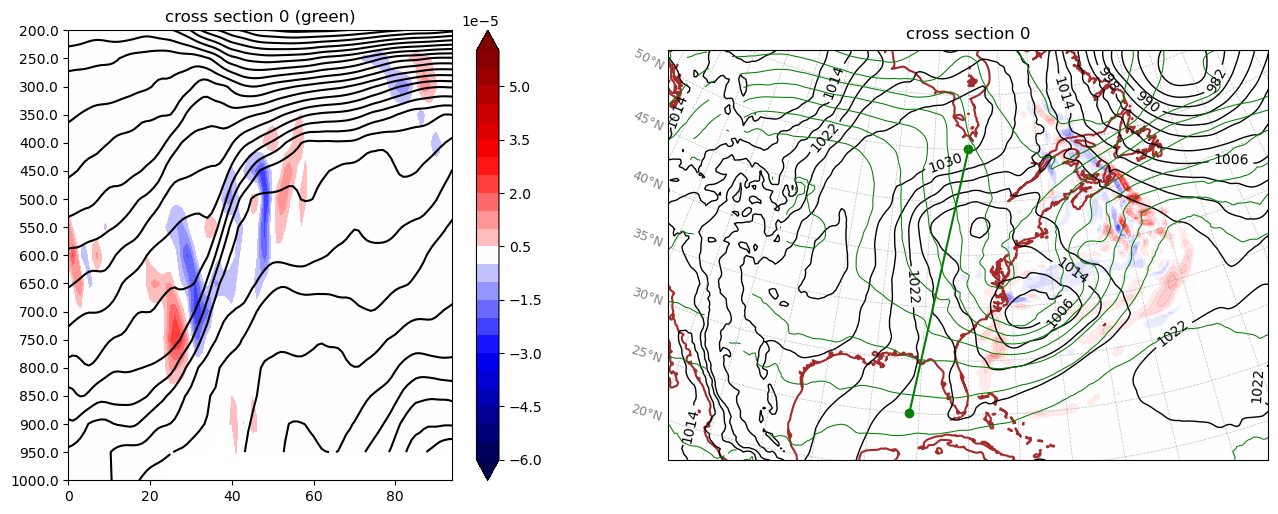

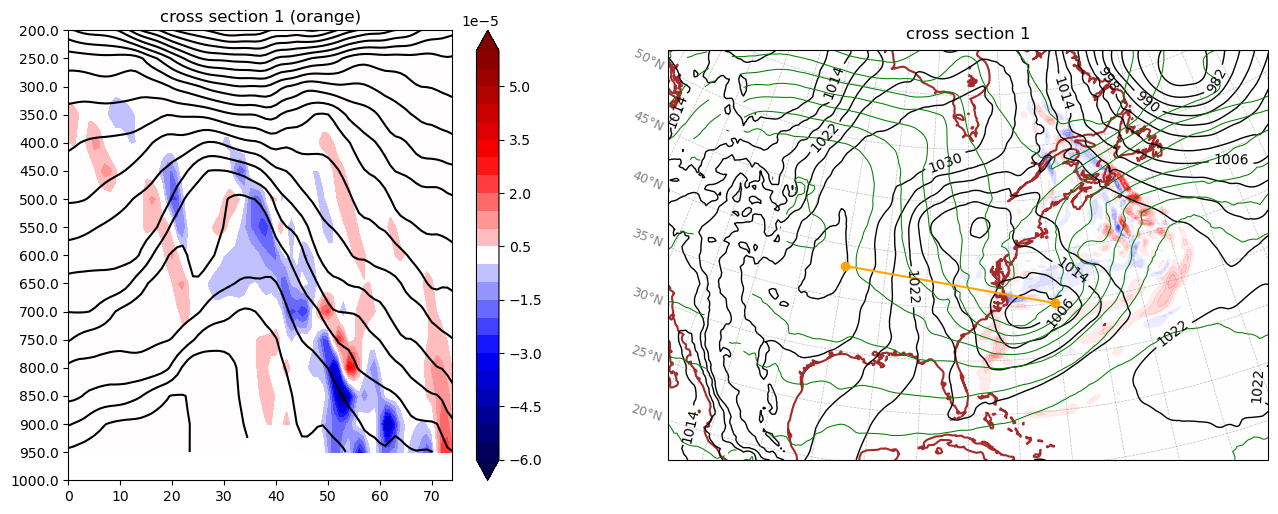

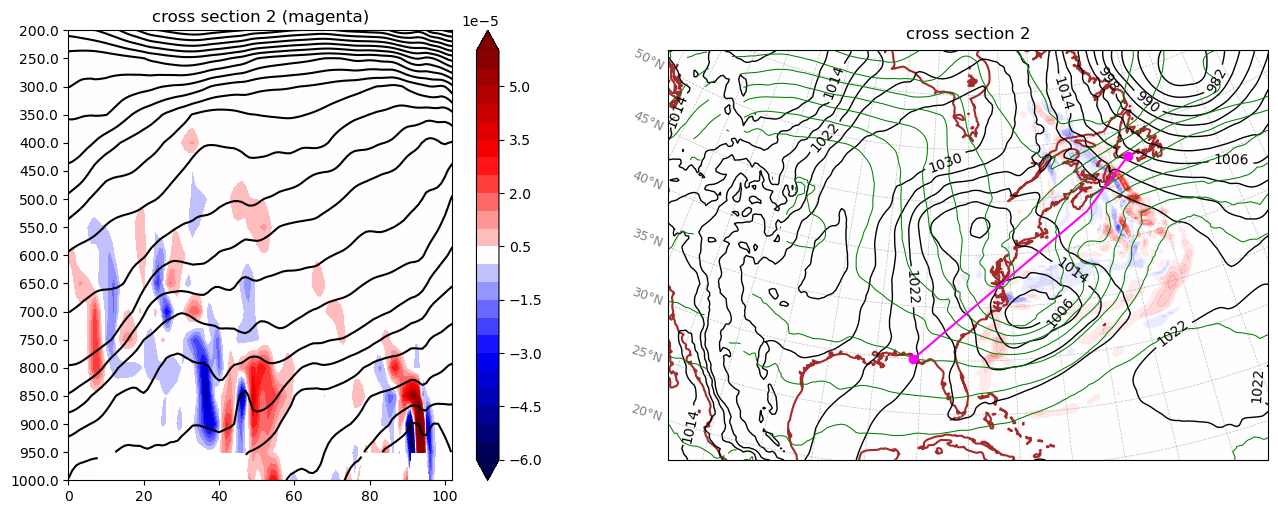

In [17]:
# cross-sections: perturbation vorticity
wrfHDL = unpHdlInit
latBegList = [ 25.0,  38.0,  30.0]
lonBegList = [-86.0, -95.0, -86.0]
latEndList = [ 50.0,  35.0,  47.5]
lonEndList = [-80.0, -70.0, -57.5]
xSectShadInterval = 1.0E-05 * np.arange(-6., 6.1, 0.5)
xSectShadInterval = xSectShadInterval[np.where(xSectShadInterval != 0.)]
slpPertInterval = np.arange(-30., 30.1, 2.)
slpPertInterval = slpPertInterval[np.where(slpPertInterval != 0.)]
fig = cross_section_plot(wrfHDL=unpHdlInit,
                         latBegList=latBegList,
                         lonBegList=lonBegList,
                         latEndList=latEndList,
                         lonEndList=lonEndList,
                         xSectContVariable=get_wrf_th(unpHdlInit),
                         xSectContInterval=np.arange(250., 450.1, 4.),
                         xSectShadVariable=ptdVORInit-unpVORInit,
                         xSectShadInterval=xSectShadInterval,
                         slp=get_wrf_slp(unpHdlInit),
                         slpInterval=np.arange(950., 1050.1, 4.),
                         thk=unpThk850_500Fcst,
                         thkInterval=np.arange(3700., 4500.1, 50.),
                         slpPert=get_wrf_slp(ptdHdlInit)-get_wrf_slp(unpHdlInit),
                         slpPertInterval=slpPertInterval,
                         datProj=datProj,
                         plotProj=plotProj,
                         presLevMin=20000.
                        )
plt.show(fig)

/home/bhoover/miniconda3/envs/UWAOS_WRF_QOIP/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


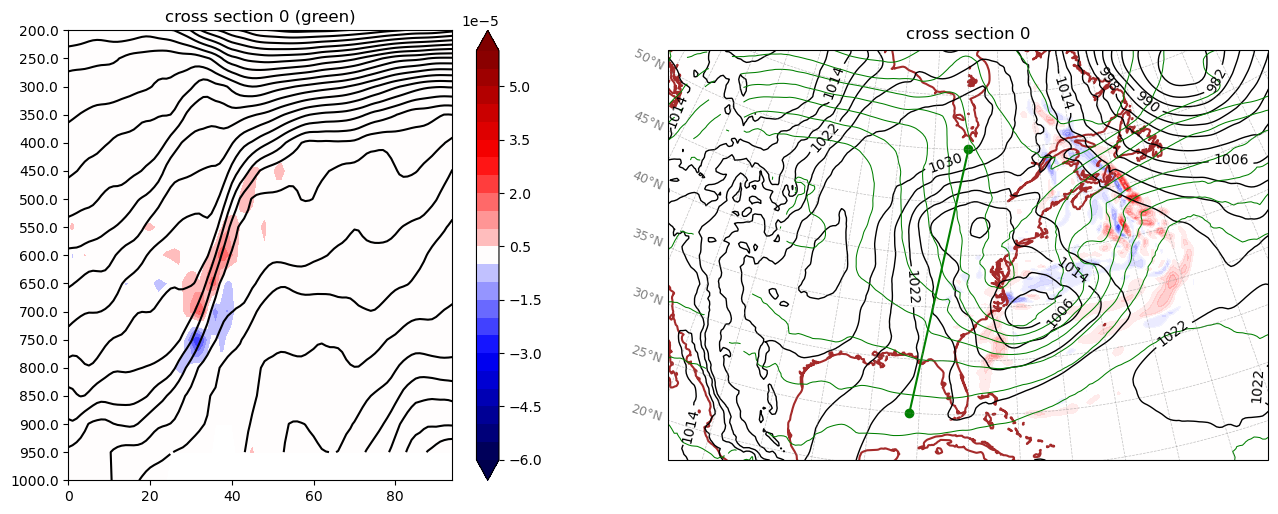

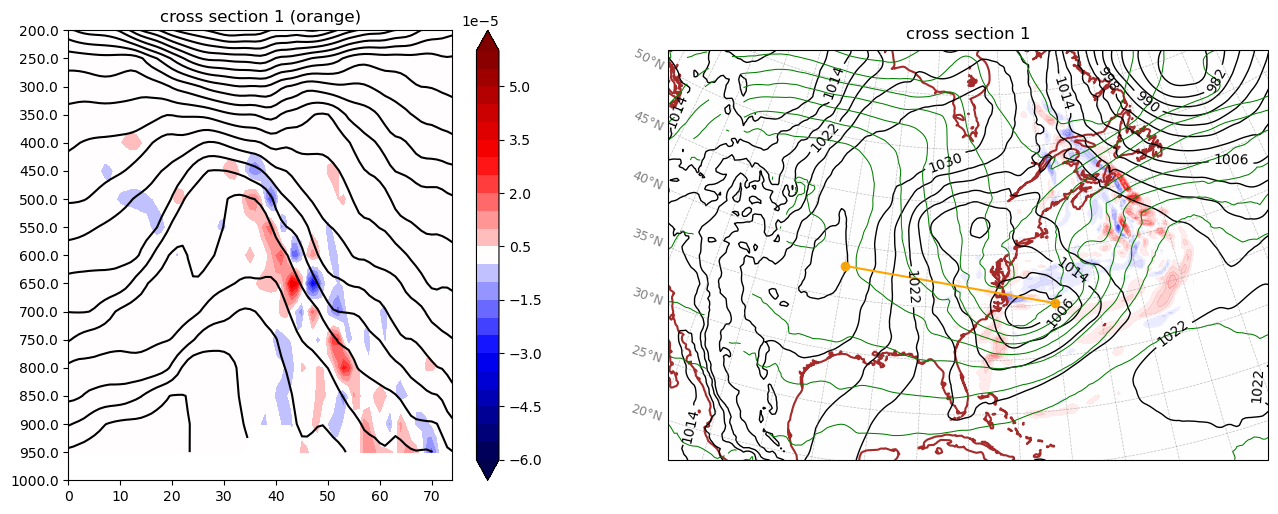

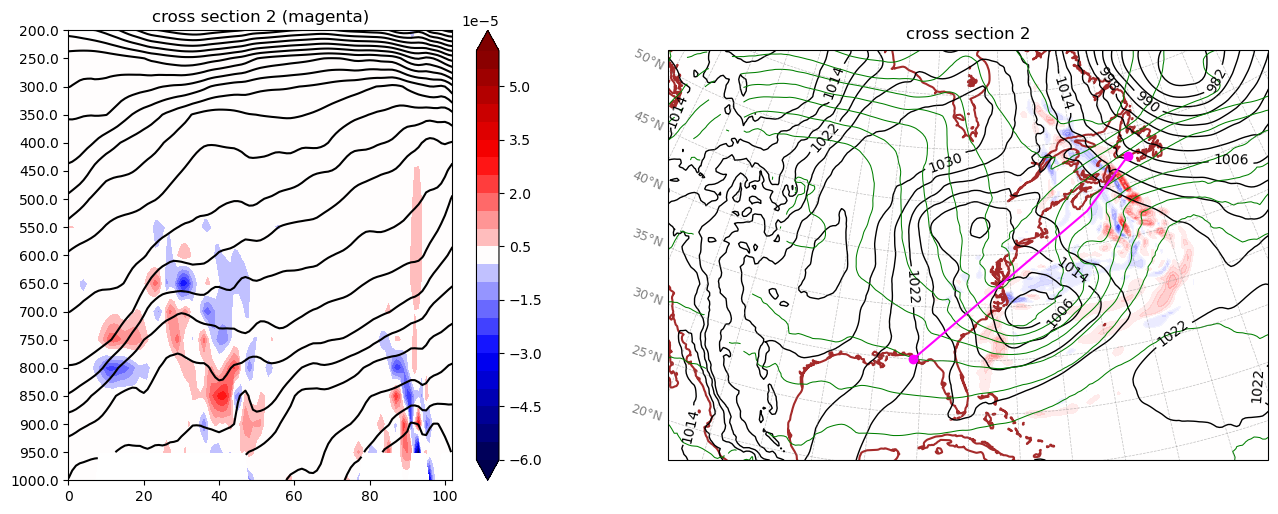

In [18]:
# cross-sections: perturbation divergence
wrfHDL = unpHdlInit
latBegList = [ 25.0,  38.0,  30.0]
lonBegList = [-86.0, -95.0, -86.0]
latEndList = [ 50.0,  35.0,  47.5]
lonEndList = [-80.0, -70.0, -57.5]
xSectShadInterval = 1.0E-05 * np.arange(-6., 6.1, 0.5)
xSectShadInterval = xSectShadInterval[np.where(xSectShadInterval != 0.)]
slpPertInterval = np.arange(-30., 30.1, 2.)
slpPertInterval = slpPertInterval[np.where(slpPertInterval != 0.)]
fig = cross_section_plot(wrfHDL=unpHdlInit,
                         latBegList=latBegList,
                         lonBegList=lonBegList,
                         latEndList=latEndList,
                         lonEndList=lonEndList,
                         xSectContVariable=get_wrf_th(unpHdlInit),
                         xSectContInterval=np.arange(250., 450.1, 4.),
                         xSectShadVariable=ptdDIVInit-unpDIVInit,
                         xSectShadInterval=xSectShadInterval,
                         slp=get_wrf_slp(unpHdlInit),
                         slpInterval=np.arange(950., 1050.1, 4.),
                         thk=unpThk850_500Fcst,
                         thkInterval=np.arange(3700., 4500.1, 50.),
                         slpPert=get_wrf_slp(ptdHdlInit)-get_wrf_slp(unpHdlInit),
                         slpPertInterval=slpPertInterval,
                         datProj=datProj,
                         plotProj=plotProj,
                         presLevMin=20000.
                        )
plt.show(fig)

/home/bhoover/miniconda3/envs/UWAOS_WRF_QOIP/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


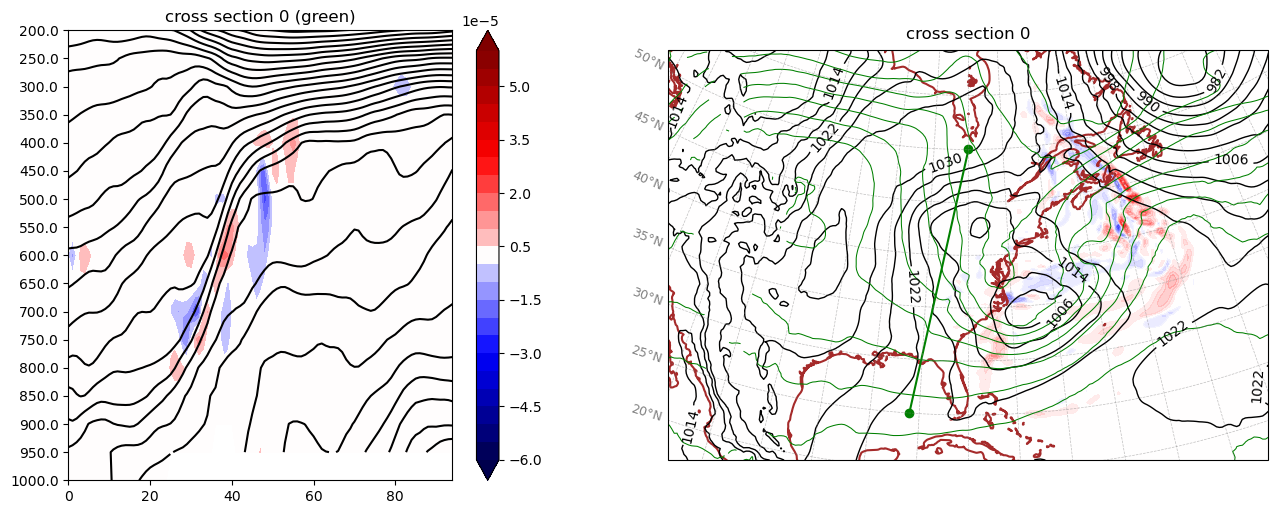

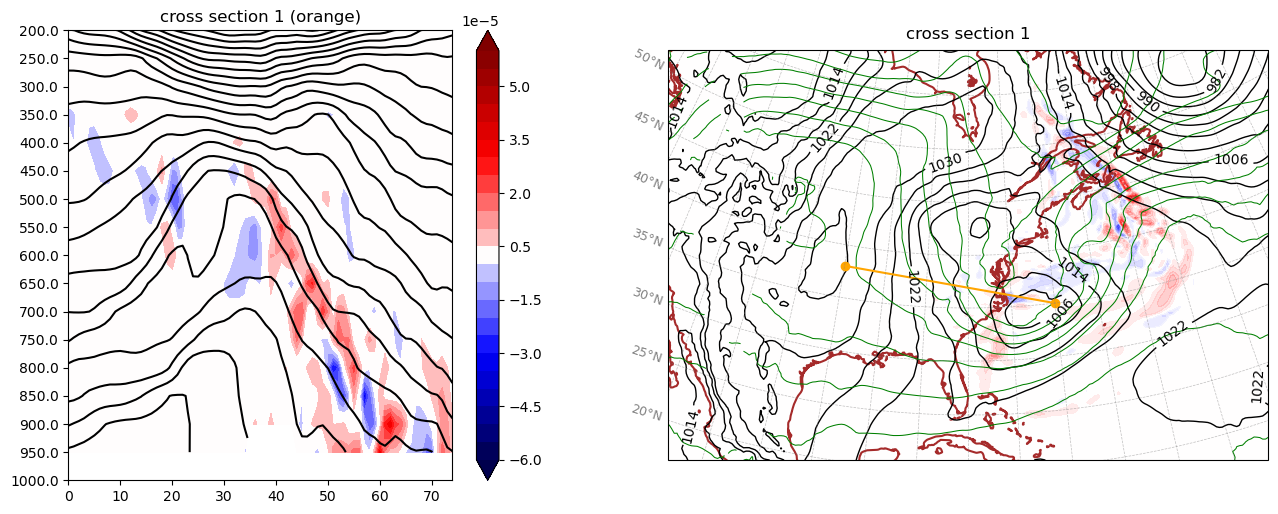

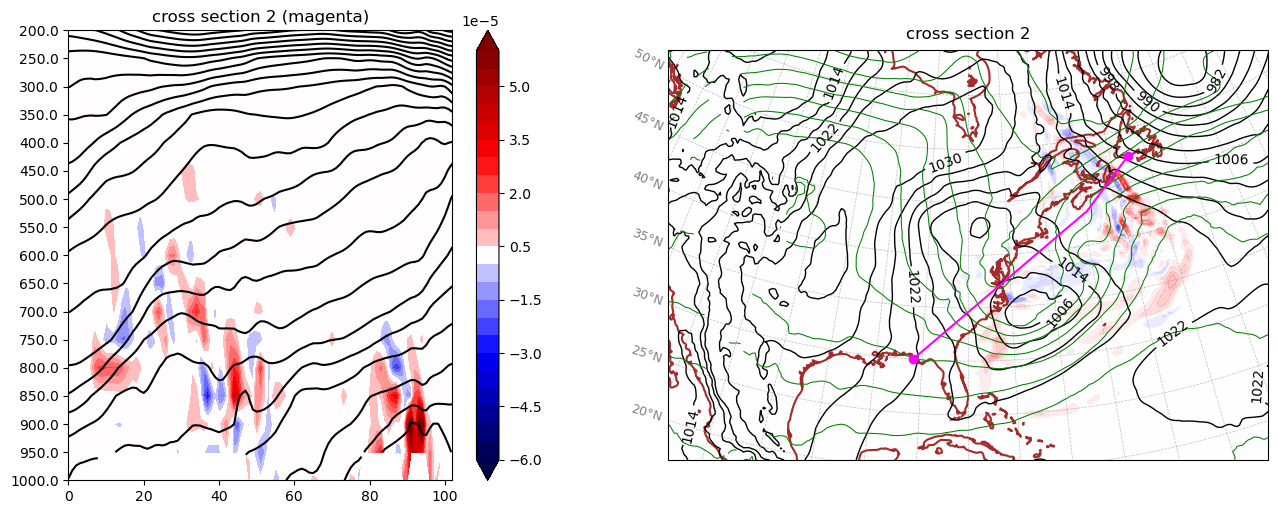

In [19]:
# cross-sections: perturbation deformation
wrfHDL = unpHdlInit
latBegList = [ 25.0,  38.0,  30.0]
lonBegList = [-86.0, -95.0, -86.0]
latEndList = [ 50.0,  35.0,  47.5]
lonEndList = [-80.0, -70.0, -57.5]
xSectShadInterval = 1.0E-05 * np.arange(-6., 6.1, 0.5)
xSectShadInterval = xSectShadInterval[np.where(xSectShadInterval != 0.)]
slpPertInterval = np.arange(-30., 30.1, 2.)
slpPertInterval = slpPertInterval[np.where(slpPertInterval != 0.)]
fig = cross_section_plot(wrfHDL=unpHdlInit,
                         latBegList=latBegList,
                         lonBegList=lonBegList,
                         latEndList=latEndList,
                         lonEndList=lonEndList,
                         xSectContVariable=get_wrf_th(unpHdlInit),
                         xSectContInterval=np.arange(250., 450.1, 4.),
                         xSectShadVariable=ptdDEFInit-unpDEFInit,
                         xSectShadInterval=xSectShadInterval,
                         slp=get_wrf_slp(unpHdlInit),
                         slpInterval=np.arange(950., 1050.1, 4.),
                         thk=unpThk850_500Fcst,
                         thkInterval=np.arange(3700., 4500.1, 50.),
                         slpPert=get_wrf_slp(ptdHdlInit)-get_wrf_slp(unpHdlInit),
                         slpPertInterval=slpPertInterval,
                         datProj=datProj,
                         plotProj=plotProj,
                         presLevMin=20000.
                        )
plt.show(fig)